### Group:
- Nooshin Shojaee
- Francesco Ciraolo
- Lucas Souza Romao

### Enviroments Setup

In [115]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from keras import regularizers, optimizers
from keras.models import Sequential

from PIL import Image
import imghdr

import matplotlib.pyplot as plt
import matplotlib.style as style

import pandas as pd
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping

In [703]:
CHANNELS = 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [704]:
train_pics_dir = '/home/lucas/Documents/ML_FinalProject/train/train/'
test_pics_dir = '/home/lucas/Documents/ML_FinalProject/test/test/'

### Data Preprocessing

- First check if the image are the type 'gif', if yes remove from the DataFrame, train and test set gif type are less than 1% of the total, so the files are drop from the DataFrames

In [705]:
def filter_images(dataset):
    
     dataset = dataset.set_index('file_name')
     
     for file in dataset.index:
         if (imghdr.what(file) == 'gif'):
            dataset = dataset.drop(file)
             
     return dataset.reset_index()  

In [706]:
def add_labels_dataframe(dataset):
    
    df = dataset.copy()
    
    for column in df.loc[:, df.columns != 'file_name']:
        df[column]= df[column].replace(1,df[column].name)
    
    df['classes'] = df.loc[:, (df.columns != 'file_name')].values.tolist()
    df['classes']= df['classes'].apply(lambda x : list(filter(lambda b: b != 0, x)))
    
    return df['classes']

In [707]:
test_df = pd.read_csv('test/test.anno.txt', sep=" ")
labels = test_df.columns
test_df['file_name'] = test_df['file_name'].apply(lambda x: os.path.join(test_pics_dir, x))
test_df

,file_name,indoor,outdoor,person,day,night,water,road,vegetation,tree,mountains,beach,buildings,sky,sunny,partly_cloudy,overcast,animal
0,/home/lucas/Documents/ML_FinalProject/test/tes...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
1,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,1,0,0,0,1,1,1,1,0,0,1,0,0,1,0
3,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
4,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,1,1,0,0,0,1,1,0,0,1,1,1,0,0,0
996,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,1,1,0,0,0,1,1,0,0,1,1,0,0,0,0
997,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0
998,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0


In [708]:
train_df = pd.read_csv('train/train.anno.txt', sep=" ", names=test_labes)
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(train_pics_dir, x))
train_df['classes'] = add_labels_dataframe(train_df)
train_df

,file_name,indoor,outdoor,person,day,night,water,road,vegetation,tree,mountains,beach,buildings,sky,sunny,partly_cloudy,overcast,animal,classes
0,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,"[outdoor, night, vegetation, tree, mountains, ..."
1,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,"[outdoor, day, mountains, sky, partly_cloudy]"
2,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,"[outdoor, night, vegetation, mountains, sky, o..."
3,/home/lucas/Documents/ML_FinalProject/train/tr...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[indoor]
4,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,"[outdoor, day, road, sky, overcast]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,"[outdoor, person, day, road, vegetation, tree,..."
1823,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,0,"[outdoor, person, day, vegetation, tree, mount..."
1824,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,1,1,0,0,0,1,1,0,0,1,1,0,0,0,0,"[outdoor, person, day, vegetation, tree, build..."
1825,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,"[outdoor, person, day, road, vegetation, tree,..."


In [709]:
train_df = filter_images(train_df)
test_df = filter_images(test_df)

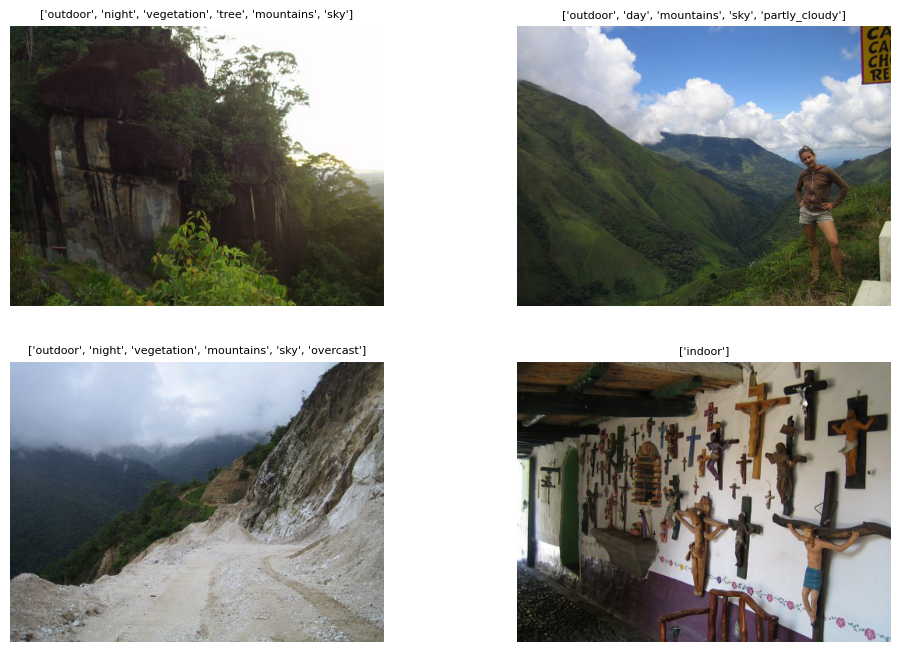

In [710]:
## Checking the images and labels 

nobs = 4 # Maximum number of images to display
ncols = 2 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(4):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(train_df['file_name'][i]))
    plt.title(train_df['classes'][i], size=8)
    plt.axis('off')

In [711]:
## Data Argumentation
image_gen = ImageDataGenerator(rescale=1./255, 
                               zoom_range=0.2, 
                               rotation_range=65,
                               shear_range=0.2, 
                               validation_split=0.2,
                               height_shift_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255.)

In [712]:
# train_data_gen = image_gen.flow_from_dataframe(dataframe=train_df,
#                                                batch_size=BATCH_SIZE,
#                                                directory=train_pics_dir,
#                                                x_col='file_name',
#                                                y_col=labels[1:].to_list(),
#                                                subset='training',
#                                                shuffle=True, seed=42, class_mode="raw",
#                                                target_size=(IMG_HEIGHT, IMG_WIDTH))

train_data_gen = image_gen.flow_from_dataframe(dataframe=train_df,
                                               batch_size=BATCH_SIZE,
                                               directory=train_pics_dir,
                                               x_col='file_name',
                                               y_col='classes',
                                               subset='training',
                                               shuffle=True, seed=42,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

val_data_gen = image_gen.flow_from_dataframe(dataframe=train_df,
                                             batch_size=BATCH_SIZE,
                                             directory=train_pics_dir,
                                             x_col='file_name',
                                             y_col='classes',
                                             subset='validation',
                                             shuffle=True, seed=42, 
                                             target_size=(IMG_HEIGHT, IMG_WIDTH))

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=test_pics_dir,
                                                x_col='file_name',
                                                y_col=None,
                                                batch_size=1,
                                                seed = 42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1460 validated image filenames belonging to 17 classes.
Found 364 validated image filenames belonging to 17 classes.
Found 997 validated image filenames.


In [713]:
import tensorflow_hub as hub
from tensorflow.keras import layers
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS))
feature_extractor_layer.trainable = False

In [728]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(17, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 17)                17425     
Total params: 3,587,153
Trainable params: 1,329,169
Non-trainable params: 2,257,984
_________________________________________________________________


### Model 

- Very simple one, needs to improve

In [671]:
activation = 'sigmoid'

In [690]:
model = Sequential()
model.add(Conv2D(120, 3, activation = activation, padding = 'same', input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
model.add(BatchNormalization())
model.add(Conv2D(120, 3, activation=activation, padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation = activation, padding = 'same'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation = activation, padding = 'same'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation = activation))
model.add(Dense(17, activation = 'softmax'))

In [729]:
#model.compile(optimizers.RMSprop(lr=0.00001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizers.Adam(lr=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

In [730]:
STEP_SIZE_TRAIN=train_data_gen.samples//train_data_gen.batch_size
STEP_SIZE_VALID=val_data_gen.samples//val_data_gen.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [731]:
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=5)

In [732]:
history = model.fit_generator(
        train_data_gen,
        steps_per_epoch = STEP_SIZE_TRAIN,
        epochs = 30,
        callbacks=[earlystop_callback],
        validation_data=val_data_gen,
        validation_steps=STEP_SIZE_VALID
)

Epoch 1/30
45/45 [==============================] - 19s 421ms/step - loss: 15.2100 - accuracy: 0.1891 - val_loss: 12.7721 - val_accuracy: 0.2670
Epoch 2/30
45/45 [==============================] - 18s 404ms/step - loss: 14.2804 - accuracy: 0.1793 - val_loss: 12.6087 - val_accuracy: 0.2330
Epoch 3/30
45/45 [==============================] - 18s 401ms/step - loss: 14.0391 - accuracy: 0.1653 - val_loss: 12.4393 - val_accuracy: 0.2216
Epoch 4/30
45/45 [==============================] - 18s 406ms/step - loss: 13.9047 - accuracy: 0.1625 - val_loss: 12.3137 - val_accuracy: 0.2102
Epoch 5/30
45/45 [==============================] - 19s 424ms/step - loss: 13.8331 - accuracy: 0.1415 - val_loss: 12.0780 - val_accuracy: 0.2188
Epoch 6/30
45/45 [==============================] - 19s 425ms/step - loss: 13.6806 - accuracy: 0.1282 - val_loss: 12.0833 - val_accuracy: 0.2074


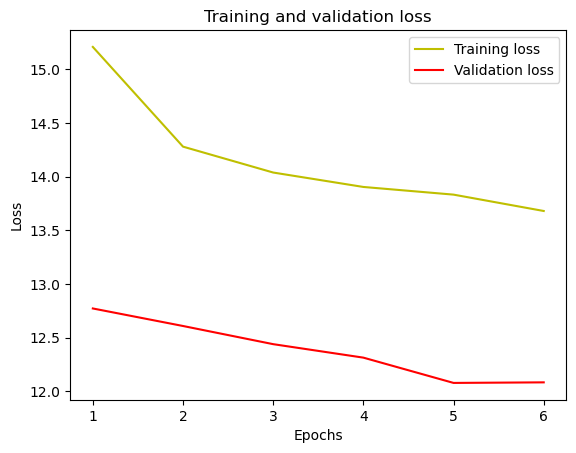

In [733]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [734]:
test_generator.reset()
pred= model.predict(test_generator,steps=STEP_SIZE_TEST, verbose=1)

997/997 [==============================] - 5s 5ms/step


In [735]:
df = pd.DataFrame(data=pred, columns=labels[1:].to_list())

In [736]:
df

,indoor,outdoor,person,day,night,water,road,vegetation,tree,mountains,beach,buildings,sky,sunny,partly_cloudy,overcast,animal
0,0.076807,0.026078,0.291668,0.933313,0.103387,0.248251,0.034815,0.943528,0.356528,0.303155,0.633734,0.286636,0.424420,0.121745,0.277115,0.609419,0.126154
1,0.095824,0.081778,0.589739,0.854078,0.122868,0.255156,0.135666,0.865009,0.379509,0.329429,0.435140,0.620415,0.672620,0.263718,0.278629,0.724445,0.375420
2,0.091354,0.055805,0.505378,0.900655,0.039673,0.108406,0.055262,0.949714,0.243738,0.192330,0.548976,0.263916,0.855219,0.195379,0.517132,0.712106,0.197176
3,0.267406,0.151279,0.366399,0.860351,0.052411,0.433783,0.056249,0.867287,0.406882,0.483582,0.523169,0.333439,0.599795,0.388009,0.340597,0.596799,0.198093
4,0.305675,0.114652,0.576735,0.895041,0.101059,0.128796,0.089061,0.936397,0.137668,0.553987,0.349456,0.227378,0.831028,0.197337,0.223056,0.781650,0.547146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.082624,0.024587,0.796445,0.940172,0.165737,0.079539,0.025759,0.976388,0.190143,0.238712,0.506026,0.284424,0.888615,0.143623,0.535964,0.767695,0.261712
993,0.033742,0.038174,0.637594,0.973159,0.073664,0.079621,0.068901,0.973527,0.152520,0.153051,0.455182,0.422396,0.754802,0.058045,0.539652,0.670636,0.095477
994,0.031983,0.040914,0.389377,0.976665,0.136042,0.093949,0.041345,0.977491,0.202531,0.205702,0.673802,0.313906,0.707520,0.034667,0.466847,0.526533,0.048677
995,0.040256,0.023984,0.711923,0.943788,0.059967,0.104272,0.043432,0.976614,0.219825,0.225420,0.231452,0.206550,0.879811,0.114334,0.540332,0.805277,0.353222
